In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn, functional as F
from torch import FloatTensor

In [ ]:
path = Path('../data/large')

In [3]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0]
bestKnow = bestKnow[:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

# Code

In [7]:
class SimpleModel(nn.Module):
    def __init__(self, d=30, w=5, nf=4):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))


class NNTest(Callback):
    def __init__(self, optim:'Optimization', m:nn.Module, loss_func:Callable=nn.MSELoss(),
                 nn_optim:torch.optim.Optimizer=torch.optim.Adam, window:int=5, min_batches:int=20, bs:int=4):
        super().__init__(optim)
        self.m,self.loss_func,self.window,self.min_batches,self.bs,self.data = m,loss_func,window,min_batches,bs,[]
        self.nn_optim = nn_optim(m.parameters())
        self.d = optim.population.dimension
        
    def on_detect_change_end(self, change_detected:bool, best:'Individual', **kwargs:Any):
        if change_detected:
            self.data.append(best.clone())
            if len(self.data) >= self.min_batches-self.window:
                self.do_train()

    def get_train_data(self)->Tuple[FloatTensor,FloatTensor]:
        w,d = self.window,self.d
        data = torch.from_numpy(np.vstack([e.data for e in self.data])).float()
        data_x,data_y = [],[]
        for i in range(data.size(0)-w):
            data_x.append(data[i:i+w])
            data_y.append(data[i+w])
        
        return torch.stack(data_x),torch.stack(data_y)

    def do_train(self)->None:
        bs,m,loss_func,nn_optim = self.bs,self.m,self.loss_func,self.nn_optim
        m.train()
        data_x,data_y = self.get_train_data()
        n_batches = math.ceil(data_x.size(0)/bs)
        
        for i in range(n_batches): # Train loop
            xb,yb = data_x[i*bs:(i+1)*bs],data_y[i*bs:(i+1)*bs]
            yb_ = m(xb)
            loss = loss_func(yb,yb_)
            loss.backward()
            nn_optim.step()
            nn_optim.zero_grad()
            import pdb; pdb.set_trace()
        

# Run

In [8]:
D = 30
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

def fitness_func(indiv): return (indiv.data**2).sum()
def constraint_func(indiv, b): return -b + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_test = partial(NNTest, m=SimpleModel(D))
opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency,
                   callbacks=[DynamicConstraint,OnChangeRestartPopulation,nn_test])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'best': None}

A proper report should be shown here :)
Total time: 00:18


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

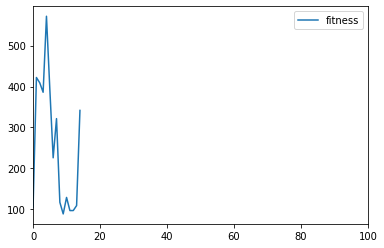

In [9]:
opt.run(total_generations)

In [8]:
data = torch.from_numpy(np.vstack([e.data for e in opt.nn_test.data]))

In [9]:
data.shape

torch.Size([10, 30])

In [21]:
w = 5
for i in range(data.size(0)-w):
    s = data[i:i+w]
    print(s.shape, i, i+w)

torch.Size([5, 30]) 0 5
torch.Size([5, 30]) 1 6
torch.Size([5, 30]) 2 7
torch.Size([5, 30]) 3 8
torch.Size([5, 30]) 4 9
